In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

import nltk
from nltk.corpus import stopwords
from textblob import TextBlob
import string
from nltk.stem.porter import PorterStemmer
from textblob import Word

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import math

from scipy.sparse import hstack
from sklearn.model_selection import KFold

# Data Pre-processing

In [2]:
def pre_process_df(df):
    df["gender"] = df["gender"].astype('category')
    df["topic"] = df["topic"].astype('category')
    df["sign"] = df["sign"].astype('category')

    df["gender_cat"] = df["gender"].cat.codes
    df["topic_cat"] = df["topic"].cat.codes
    df["sign_cat"] = df["sign"].cat.codes
    
    df["gender_cat"] = df["gender_cat"].astype('category')
    df["topic_cat"] = df["topic_cat"].astype('category')
    df["sign_cat"] = df["sign_cat"].astype('category')

def get_word_count(df):
    df['word_count'] = df['text'].apply(lambda x: len(str(x).split(" ")))
    

In [3]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442961 entries, 0 to 442960
Data columns (total 8 columns):
post.id    442961 non-null int64
user.id    442961 non-null int64
gender     442961 non-null object
topic      442961 non-null object
sign       442961 non-null object
date       442961 non-null object
text       442961 non-null object
age        442961 non-null int64
dtypes: int64(3), object(5)
memory usage: 27.0+ MB


In [5]:
pre_process_df(train)
pre_process_df(test)
get_word_count(train)
get_word_count(test)

## Data Processing on the Text Column

## Grouping the data by USER ID
### (found no change in gender,age, or topic across user.id at time of collecting data)

In [84]:
def remove_spaces_from_text_col(df):
    
    # replace &nbsp; or Non-Breaking spaces with normal spaces
#     df['text'] = df['text'].apply(lambda x: re.sub('&nbsp;', ' ',str(x)))
    # remove duplicate spaces
    df['text'] = df['text'].apply(lambda x: re.sub(' +', ' ',str(x)))
    # strip spaces around the sentence string
    df['text'] = df['text'].apply(lambda x: str(x).strip())


def group_by_user_id_col(df):
    # group by user id and get all the categorical variables
    cat = df.groupby(['user.id'])['topic','gender', 'sign','topic_cat','gender_cat', 'sign_cat' ].first()
    cat.columns = ['topic','gender', 'sign','topic_cat','gender_cat', 'sign_cat' ]
    
    # group by user id and get all text written by the user
    text = df.groupby(['user.id'])['text'].apply(lambda x:' '.join(x))
    
    # check for age column and get the age of each user
    if 'age' in df.columns:
        age = df.groupby(['user.id'])['age'].agg(np.average)
        return cat, text, age
        
    return cat, text

def feature_creation(df):
    # get the total word count for each user
    tot_word_count = df.groupby(['user.id'])['word_count'].agg(np.sum)
    tot_word_count.name = 'tot_word_count'
    
    # get average word count for each user
    avg_word_count = df.groupby(['user.id'])['word_count'].agg(np.average)
    avg_word_count.name = 'avg_word_count'
    
    # get the number of posts by each user
    num_of_text = df.groupby(['user.id'])['user.id'].agg(['count'])
    num_of_text.columns = ['num_of_text']
    
    return tot_word_count, avg_word_count, num_of_text

def create_final_df(feature_dfs): # pass list of feature data frames created; returns concatenated data frame
    
    final_df = pd.concat(feature_dfs, axis=1)
    final_df = final_df.reset_index()
    
    return final_df
        

In [85]:
remove_spaces_from_text_col(train)
cat, text, age = group_by_user_id_col(train)
tot_word_count, avg_word_count, num_of_text = feature_creation(train)
final_df = create_final_df([cat, text, age, tot_word_count, avg_word_count, num_of_text])

In [67]:
final_df["gender_cat"] = final_df["gender_cat"].astype('category')
final_df["topic_cat"] = final_df["topic_cat"].astype('category')
final_df["sign_cat"] = final_df["sign_cat"].astype('category')

In [68]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12880 entries, 0 to 12879
Data columns (total 12 columns):
user.id           12880 non-null int64
topic             12880 non-null object
gender            12880 non-null object
sign              12880 non-null object
topic_cat         12880 non-null category
gender_cat        12880 non-null category
sign_cat          12880 non-null category
text              12880 non-null object
age               12880 non-null int64
tot_word_count    12880 non-null int64
avg_word_count    12880 non-null float64
num_of_text       12880 non-null int64
dtypes: category(3), float64(1), int64(4), object(4)
memory usage: 945.5+ KB


# Exploring the data

### Gender Division

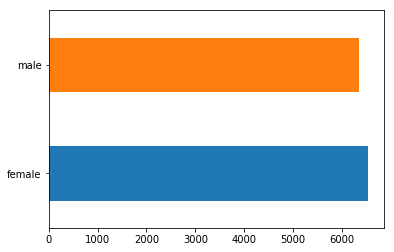

In [69]:
# train.groupby(['user.id'])['gender'].value_counts().plot(kind='barh')
final_df['gender'].value_counts().plot(kind='barh')
plt.show()

### Top 10 Topics by Frequency

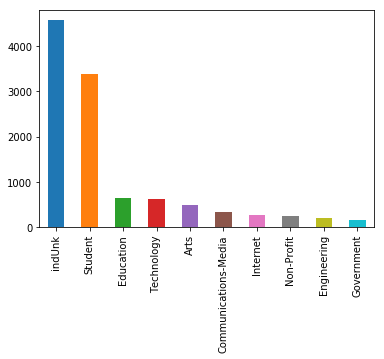

In [11]:
final_df['topic'].value_counts()[:10].plot(kind='bar')
plt.show()

### Distribution of Signs

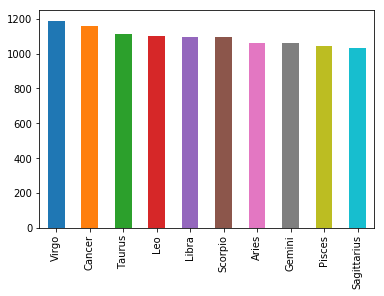

In [12]:
final_df['sign'].value_counts()[:10].plot(kind='bar')
plt.show()

# Working with the text column grouped data frame
## Removing stop words and punctuation

In [11]:
def text_processing(df):
    # get stop words from NLTK
    stop = stopwords.words('english')
    
    # remove stop words from the text
    df['text_processed'] = df['text'].apply(lambda x : " ".join(x for x in x.split() if x not in stop))

    # removing punctuation 
    df['text_processed'] = df['text_processed'].str.replace('[^\w\s]','')
    
    # ignore case
    df['text_processed'] = df['text_processed'].str.lower()
    
    # count number of numerical values in the text
    df['numerics'] = df['text_processed'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
    
    # remove numbers from the text
    df['text_processed'] = df['text_processed'].str.replace('\d+', '')
    
    # get word roots
    df['text_processed'] = df['text_processed'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
    
    return df


In [70]:
final_df = text_processing(final_df)

In [71]:
final_df['specials'] = final_df['text_processed'].apply(lambda x: len(re.sub('[^\^&*#]+' ,'', x)))
final_df['count_slang'] = final_df.text_processed.str.count('lol|tbt|smh|tbh|lel|lmao|omg|wtf|ikr|lmfao')

In [76]:
# final_df.drop(['specials'], axis=1, inplace=True)
final_df.text_processed[6]

'well day left le hour i presence favorite band world for know is it dave matthew band man i even love namejkor i anyway i little tired last night i got home ish still wound head i am i stuff mind friend mine went eat me she beautiful personality physically kind caringi could go i dont need to she helped lot lately know anyway ate talked i still wired i got home i played online poker dad hooked watching it i play online little fun it i listened dave becasue talking last night got onto subject i told one song reminded something came conversation some may know it say goodbye one time favs anywayonce got done eating wanted hear it dave cd i made it we got car listened couple song got one it is hard for me to skip dave song to get to just one ok so i made listen couple others first anyway point story i got dave mood i earlier i still christian mood concert past weekend btw take much get dave mood still i really craving then a i writing post i listening central park cd great cd best live sh

# Extracting TF-IDF from the text data

In [77]:
# extract tf_idf for 1000 words with highest tf-idf values across all documents
# parameters: 
# min_df = 5 , ignore terms that appear in less than 5 documents
# max_df = 0.5, ignore terms that appear in more than 50% of the documents"
vectorizer = TfidfVectorizer(min_df=10, max_features=100)
X_tfidf = vectorizer.fit_transform(final_df['text_processed']) 

In [78]:
X_tfidf = X_tfidf.todense()

In [79]:
# extract the features created on the final training dataframe
features_used = ['topic_cat', 'avg_word_count','num_of_text','count_slang']
X_feature = final_df[features_used]
# stack the tf-idf and other features together
X = np.concatenate((X_tfidf,X_feature.values), axis=1)
# get the outcome variable from the data frame
y = final_df.age

X.shape

## K-Fold cross validation

test_mse_avg_means = []
test_mse_avg_stds = []
test_mae_avg_means = []
test_mae_avg_stds = []
for i in range(1):
    kf = KFold(n_splits=10, shuffle=True)

    kfold_linreg = LinearRegression()
    test_mse = []
    test_mae = []

    for train_index, test_index in kf.split(X):
        X_train = X[train_index]
        y_train = y[train_index]
        X_test = X[test_index]
        y_test = y[test_index]
    
        # train model
        kfold_linreg.fit(X_train,y_train)
    
        y_pred = kfold_linreg.predict(X_test)
    
        mse = mean_squared_error(y_test,y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        test_mse.append(mse)
        test_mae.append(mae)

    #test mae
    std_test_mae = np.std(test_mae)
    avg_test_mae = np.mean(test_mae)
    test_mae_avg_means.append(avg_test_mae)
    test_mae_avg_stds.append(std_test_mae)
    
    #test_mse
    std_test_mse = np.std(test_mse)
    avg_test_mse = np.mean(test_mse)
    test_mse_avg_means.append(avg_test_mse)
    test_mse_avg_stds.append(std_test_mse)

In [80]:
print(np.mean(test_mae_avg_means))
print(np.mean(test_mae_avg_stds))
print(np.mean(test_mse_avg_means))
print(np.mean(test_mse_avg_stds))

4.709722575037447
0.06688696780785751
40.123807332338195
1.289132481309919


## Checking different features

In [81]:
# extract the features created on the final training dataframe
features_used = ['topic_cat', 'avg_word_count','num_of_text','count_slang', 'numerics']
X_feature = final_df[features_used]
# stack the tf-idf and other features together
X = np.concatenate((X_tfidf,X_feature.values), axis=1)
# get the outcome variable from the data frame
y = final_df.age

X.shape

(12880, 105)

In [82]:
## K-Fold cross validation

test_mse_avg_means = []
test_mse_avg_stds = []
test_mae_avg_means = []
test_mae_avg_stds = []
for i in range(1):
    kf = KFold(n_splits=10)

    kfold_linreg = LinearRegression(normalize=True)
    test_mse = []
    test_mae = []

    for train_index, test_index in kf.split(X):
        X_train = X[train_index]
        y_train = y[train_index]
        X_test = X[test_index]
        y_test = y[test_index]
    
        # train model
        kfold_linreg.fit(X_train,y_train)
    
        y_pred = kfold_linreg.predict(X_test)
    
        mse = mean_squared_error(y_test,y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        test_mse.append(mse)
        test_mae.append(mae)

    #test mae
    std_test_mae = np.std(test_mae)
    avg_test_mae = np.mean(test_mae)
    test_mae_avg_means.append(avg_test_mae)
    test_mae_avg_stds.append(std_test_mae)
    
    #test_mse
    std_test_mse = np.std(test_mse)
    avg_test_mse = np.mean(test_mse)
    test_mse_avg_means.append(avg_test_mse)
    test_mse_avg_stds.append(std_test_mse)

In [83]:
print(np.mean(test_mae_avg_means))
print(np.mean(test_mae_avg_stds))
print(np.mean(test_mse_avg_means))
print(np.mean(test_mse_avg_stds))

4.70685644010229
0.10634147569312109
40.14952200636579
2.208405211643968


In [56]:
print(np.mean(test_mae_avg_means))
print(np.mean(test_mae_avg_stds))
print(np.mean(test_mse_avg_means))
print(np.mean(test_mse_avg_stds))

4.22922151373935
0.1027445188239855
32.28747343613232
2.012983339041023


## Making the model

In [65]:
# split the data into 80 percent train and 20 percent test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=4200)

In [186]:
# make a linear regression model
linreg = LinearRegression()

linreg.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [23]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12880 entries, 0 to 12879
Data columns (total 15 columns):
user.id           12880 non-null int64
topic             12880 non-null object
gender            12880 non-null object
sign              12880 non-null object
topic_cat         12880 non-null category
gender_cat        12880 non-null category
sign_cat          12880 non-null category
text              12880 non-null object
age               12880 non-null int64
tot_word_count    12880 non-null int64
avg_word_count    12880 non-null float64
num_of_text       12880 non-null int64
text_processed    12880 non-null object
numerics          12880 non-null int64
count_slang       12880 non-null int64
dtypes: category(3), float64(1), int64(6), object(5)
memory usage: 1.2+ MB


In [151]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12880 entries, 0 to 12879
Data columns (total 16 columns):
user.id           12880 non-null int64
topic             12880 non-null object
gender            12880 non-null object
sign              12880 non-null object
topic_cat         12880 non-null int8
gender_cat        12880 non-null int8
sign_cat          12880 non-null int8
text              12880 non-null object
age               12880 non-null int64
tot_word_count    12880 non-null int64
avg_word_count    12880 non-null float64
num_of_text       12880 non-null int64
text_processed    12880 non-null object
numerics          12880 non-null int64
count_lol         12880 non-null int64
count_slang       12880 non-null int64
dtypes: float64(1), int64(7), int8(3), object(5)
memory usage: 1.3+ MB


In [87]:
avg_test_mse = np.mean(test_mse)
avg_test_mse

33.06301015228762

## Making predictions

In [174]:
remove_spaces_from_text_col(test)
cat, text = group_by_user_id_col(test)
tot_word_count, avg_word_count, num_of_text = feature_creation(test)
test_df = create_final_df([cat, text, tot_word_count, avg_word_count, num_of_text])

In [175]:
test_df = text_processing(test_df)

In [ ]:
test_df["gender_cat"] = test_df["gender_cat"].astype('category')
test_df["topic_cat"] = test_df["topic_cat"].astype('category')
test_df["sign_cat"] = test_df["sign_cat"].astype('category')

In [184]:
test_df['count_slang'] = test_df.text_processed.str.count('lol|tbt|smh|tbh|lel|lmao|omg|wtf|ikr')
test_df.head(2)

,user.id,topic,gender,sign,topic_cat,gender_cat,sign_cat,text,tot_word_count,avg_word_count,num_of_text,text_processed,numerics,count_slang
0,2,Military,male,Taurus,26,1,10,I finally saw Nathan's tattoo tonight. I like ...,833,119.000000,7,i finally saw nathans tattoo tonight i like it...,6,0
1,8,indUnk,male,Aquarius,39,1,0,Today was the last day and the shortest. We ha...,11790,170.869565,69,today last day shortest we one session lasted ...,147,0


In [229]:
# get the tf-idf of the same vocabulary of words learnt while fitting
X_test = vectorizer.transform(test_df['text_processed'])
X_test = X_test.todense()
# get the same feature from the test data as from the train data set
X_test_cat = test_df[features_used]
# stack the tf-idf and extracted features together
X_test_mat = np.concatenate((X_test,X_test_cat.values), axis=1)

In [231]:
X_test_mat.shape

(6440, 1005)

In [191]:
# predict on the test data
y_pred_test = linreg.predict(X_test_mat)

In [192]:
# write predictions to file
y_pred_test = pd.Series(y_pred_test)
predictions = pd.concat([test_df['user.id'], y_pred_test], axis=1)
predictions.columns = ['user.id','age']
predictions.age = np.floor(predictions.age)
predictions.to_csv('./predictions_text_test.csv', index=False)